In [3]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
data_passengers = pd.read_csv('passengers.csv', index_col = 'Month', parse_dates = True)
data_passengers.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [18]:
data_passengers.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


## Сдвиг вперед-назад

In [19]:
data_passengers.shift(2, axis = 0).head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,112.0
1949-04-01,118.0
1949-05-01,132.0


## Скользящее среднее

In [20]:
data_passengers.rolling(window = 3).mean().head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,120.666667
1949-04-01,126.333333
1949-05-01,127.333333


[Text(0.5, 1.0, 'Перевозки'),
 Text(0.5, 0, 'Месяцы'),
 Text(0, 0.5, 'Количество пассажиров')]

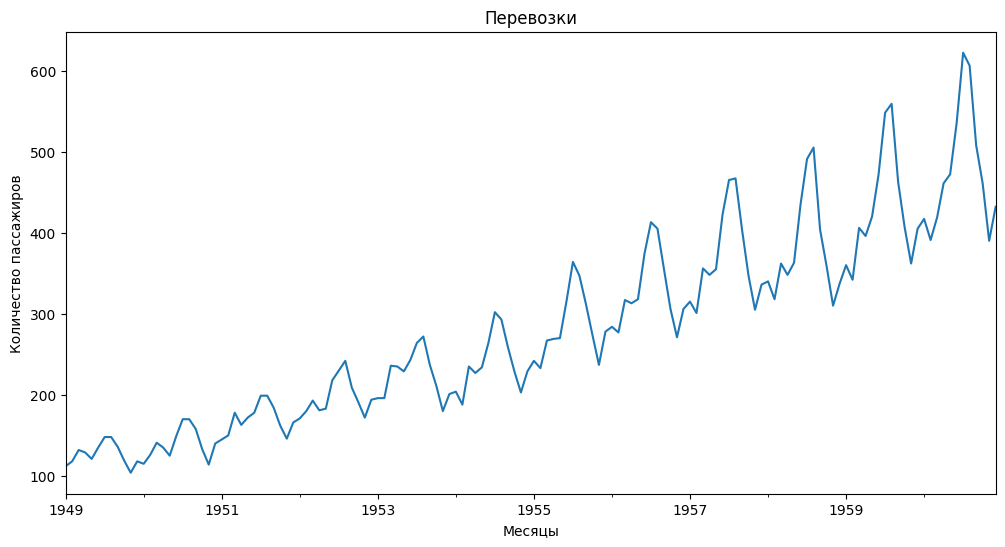

In [21]:
ax = data_passengers.plot(figsize = (12,6), legend = None)
ax.set(title = 'Перевозки', xlabel = 'Месяцы', ylabel = 'Количество пассажиров')

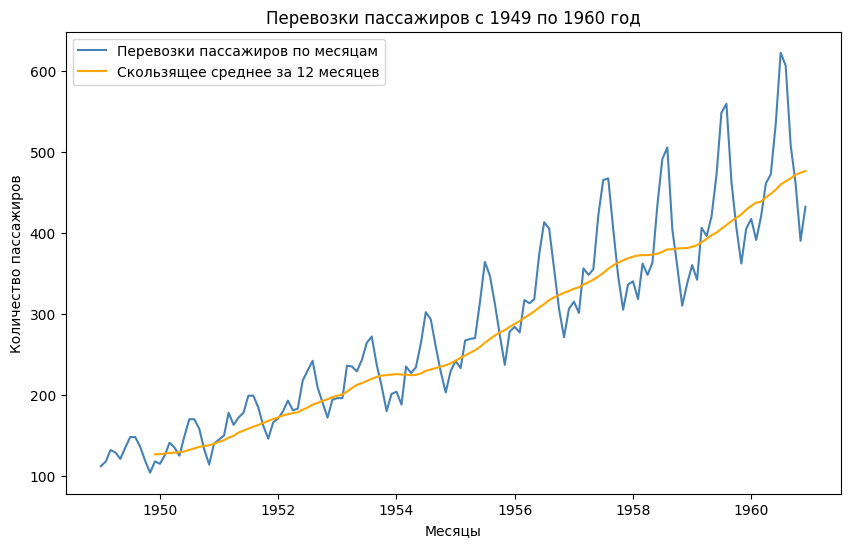

In [22]:
plt.figure(figsize = (10,6))
plt.plot(data_passengers, label = 'Перевозки пассажиров по месяцам', color = 'steelblue')
plt.plot(data_passengers.rolling(window = 12).mean(), label = 'Скользящее среднее за 12 месяцев', color = 'orange')
plt.legend(title = '', loc = 'upper left')
 
plt.xlabel('Месяцы')
plt.ylabel('Количество пассажиров')
plt.title('Перевозки пассажиров с 1949 по 1960 год')
 
plt.show()

## Еще одни данные

In [23]:
births = pd.read_csv('births.csv', index_col = 'Date', parse_dates = True)
births.head(3)

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30


In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

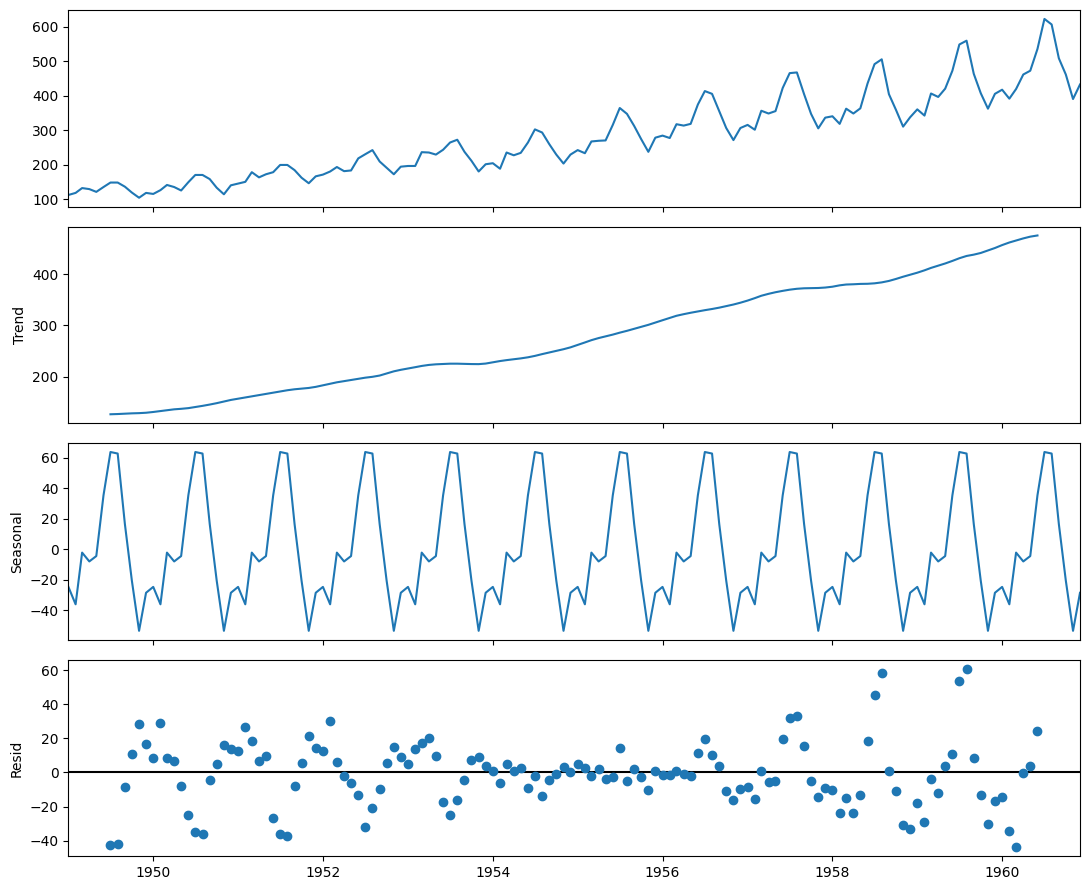

In [25]:
rcParams['figure.figsize'] = 11, 9

decompose = seasonal_decompose(data_passengers)
decompose.plot()
 
plt.show()

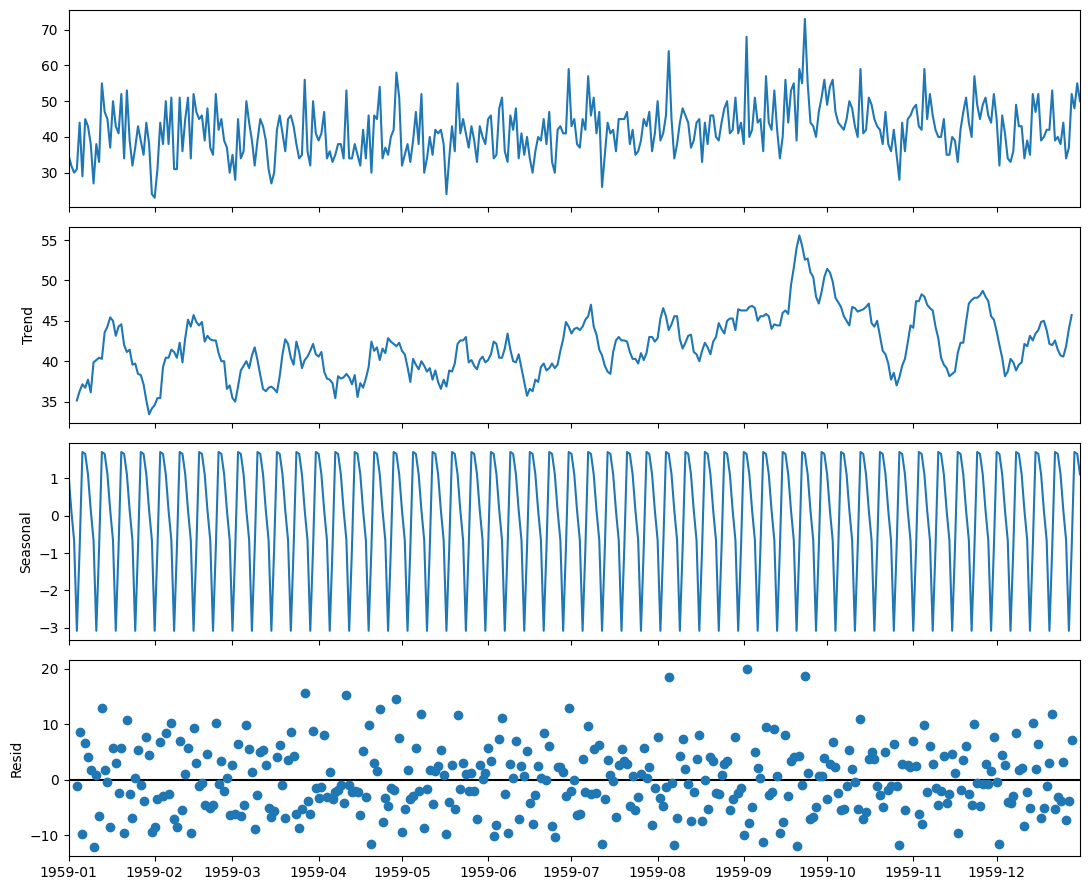

In [26]:
decompose = seasonal_decompose(births)
decompose.plot()
 
plt.show()

## Визуально можно сказать, что датасет с днями рождениями стационарен, в отличие от датасета про пассажиров.

### <strong>Test ADF</strong> c помощью statsmodels

In [27]:
import numpy as np

In [28]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(births['Births'])
 
# выведем p-value
print(f'p-value = {adf_test[1]}')
if adf_test[1] < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

p-value = 5.243412990149865e-05
Ряд стационарен


### Мой тест ADF

In [29]:
def adf_test(series, num_lag):

    y = np.array(series.iloc[:, 0])
    
    y_lag = y[:-num_lag]
    delta_y = np.diff(y, n=num_lag)

    X = np.column_stack((np.ones(len(y_lag)), y_lag))
    beta = np.linalg.lstsq(X, delta_y, rcond=None)[0]
    alpha, gamma = beta

    delta_y_hat = np.dot(X, beta)

    # Вычисление ошибок (остатков)
    errors = delta_y - delta_y_hat

    n = len(delta_y)
    k = 2  # количество параметров (альфа и гамма)
    SE_gamma = np.sqrt(np.sum(errors**2) / (n - k)) / np.sqrt(np.sum((y_lag - np.mean(y_lag))**2))
    DF = gamma / SE_gamma

    # Вывод результатов
    print(f"Оценка альфа: {alpha}")
    print(f"Оценка гаммы: {gamma}")
    print(f"Стандартная ошибка для гаммы: {SE_gamma}")
    print(f"ADF статистика: {DF}")

    # Для критического значения на уровне значимости 10% (примерно -2.89 для длинных рядов)
    critical_value = -2.89
    if DF < critical_value:
        print("Нулевая гипотеза отвергается, ряд стационарен.")
    else:
        print("Нулевая гипотеза не отвергается, ряд не стационарен.")

In [30]:
adf_test(births, 1)

Оценка альфа: 32.854489735445696
Оценка гаммы: -0.7820358975775702
Стандартная ошибка для гаммы: 0.05131661240982342
ADF статистика: -15.239429511287593
Нулевая гипотеза отвергается, ряд стационарен.


In [31]:
passengers = pd.read_csv('passengers.csv', index_col = 'Month', parse_dates = True)
passengers.head(3)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132


In [32]:
adf_test(passengers, 1)

Оценка альфа: 13.705504997522253
Оценка гаммы: -0.04106802270530872
Стандартная ошибка для гаммы: 0.02349304429650292
ADF статистика: -1.748092847695432
Нулевая гипотеза не отвергается, ряд не стационарен.


## <strong>Метод Хольта</strong>

In [33]:
def holt_method(series, alpha, beta, initial_level, initial_trend):

    y = np.array(series)
    series_len = len(y)

    l = np.zeros(series_len)
    b = np.zeros(series_len)
    l[0] = initial_level
    b[0] = initial_trend

    for i in range(1, series_len):
        l[i] = alpha * y[i] + (1 - alpha)*(l[i-1] + b[i-1])
        b[i] = beta*(l[i] - l[i-1]) + (1 - beta)*b[i-1]

    forecast = l + b
    return forecast, l, b

In [34]:
passengers_data = pd.read_csv('passengers.csv', index_col='Month', parse_dates=True)
passengers = passengers_data.iloc[:, 0]

alpha = 0.5
beta = 0.4
initial_level = passengers.iloc[0]
initial_trend = passengers.iloc[1] - passengers.iloc[0] 

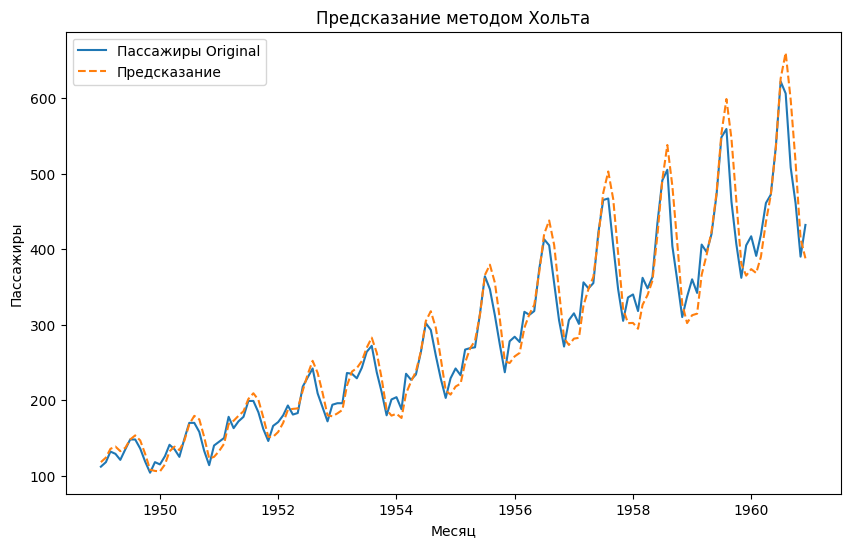

In [35]:
forecast, level, trend = holt_method(passengers, alpha, beta, initial_level, initial_trend)

plt.figure(figsize=(10, 6))
plt.plot(passengers.index, passengers, label='Пассажиры Original')
plt.plot(passengers.index, forecast, label='Предсказание', linestyle='--')
plt.xlabel('Месяц')
plt.ylabel('Пассажиры')
plt.title('Предсказание методом Хольта')
plt.legend()
plt.show()

### Минимизация ошибки подбор параметров альфа и бета

In [36]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [37]:
def mse(actual, forecast):
    return mean_squared_error(actual, forecast)

def optimize(series):
    initial_level = series.iloc[0]
    initial_trend = series.iloc[1] - series.iloc[0]

    def error(params):
        alpha, beta = params
        forecast, _, _ = holt_method(series, alpha, beta, initial_level, initial_trend)
        return mse(series, forecast)
    
    result = minimize(error, x0=[0.5, 0.5], bounds=[(0, 1), (0, 1)], method='L-BFGS-B')
    return result.x

In [38]:
optimal_params = optimize(passengers)
alpha, beta = optimal_params
print(f"Подобранное альфа: {alpha}")
print(f"Подобранное бета: {beta}")

Подобранное альфа: 0.9860947465768929
Подобранное бета: 0.03388145064425163


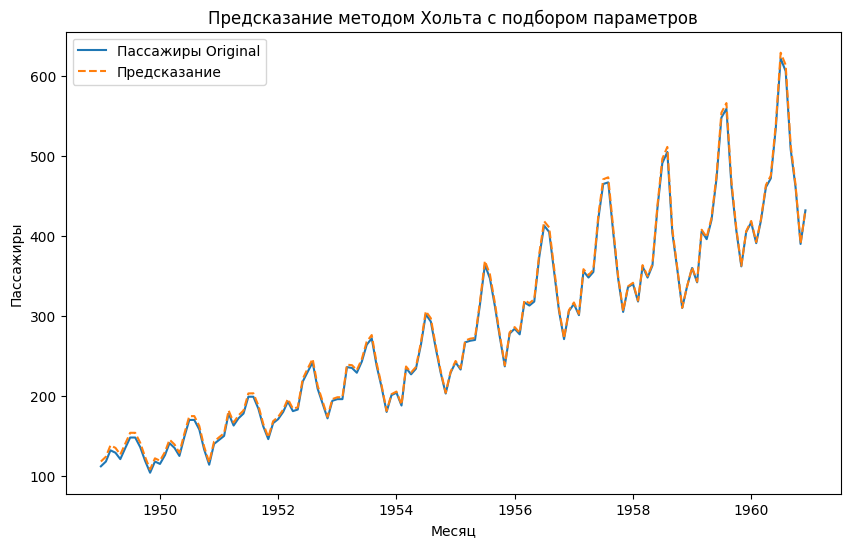

In [39]:
forecast, level, trend = holt_method(passengers, alpha, beta, initial_level, initial_trend)

plt.figure(figsize=(10, 6))
plt.plot(passengers.index, passengers, label='Пассажиры Original')
plt.plot(passengers.index, forecast, label='Предсказание', linestyle='--')
plt.xlabel('Месяц')
plt.ylabel('Пассажиры')
plt.title('Предсказание методом Хольта с подбором параметров')
plt.legend()
plt.show()

In [40]:
forecast_error = mse(passengers, forecast)
print(f"Среднеквадратичная ошибка: {forecast_error}")

Среднеквадратичная ошибка: 13.128968286894313


### Метод Хольта с помощью statsmodels

In [41]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


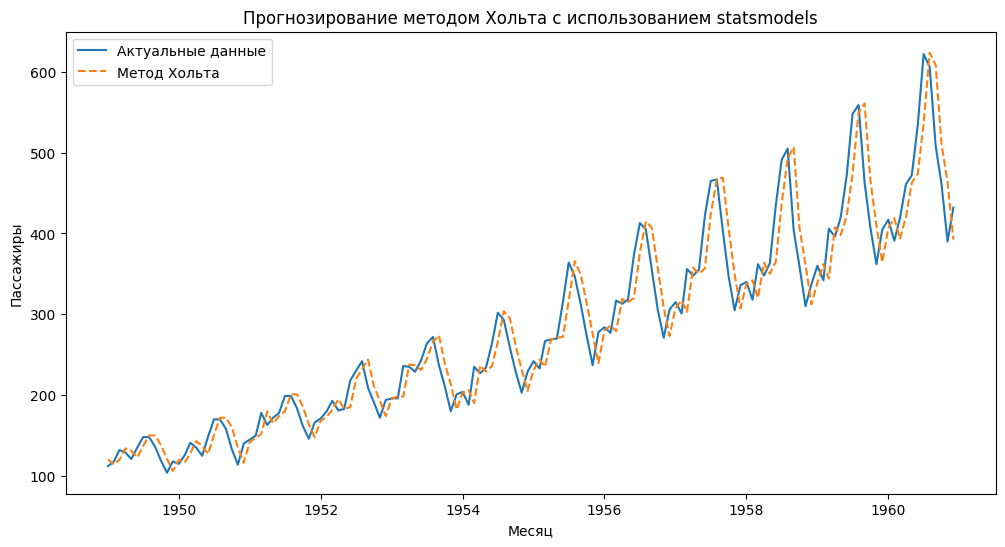

In [42]:
passengers_data = pd.read_csv('passengers.csv', index_col='Month', parse_dates=True)
passengers = passengers_data.iloc[:, 0]

model = ExponentialSmoothing(passengers, trend='add', seasonal=None, damped_trend=False)
fit = model.fit()

plt.figure(figsize=(12, 6))
plt.plot(passengers.index, passengers, label='Актуальные данные')
plt.plot(passengers.index, fit.fittedvalues, label='Метод Хольта', linestyle='--')
plt.xlabel('Месяц')
plt.ylabel('Пассажиры')
plt.title('Прогнозирование методом Хольта с использованием statsmodels')
plt.legend()
plt.show()

In [45]:
print(f'Ошибка MSE для метода Хольта из statsmodels: {mean_squared_error(passengers, fit.fittedvalues)}')

Ошибка MSE для метода Хольта из statsmodels: 1127.5983871529706
